In [1]:
#MLND Capstone Project
#Richard Pritchett/rp7822@att.com
#Submitted 9/24/18



import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from time import time

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

#The following line suppresses the "future warning" errors that cluttered my original runs through this
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline


##### Load the breast cancer dataset
try:
    
    #Read in my dataset
    bcdata = pd.read_csv('../input/data.csv')

    #Preprocessing
    #Preprocess to identify nulls
    missing_val_count_by_column = (bcdata.isnull().sum())
    print(missing_val_count_by_column)
    
    #Take a look at the data to visually confirm it is what was expected
    display(bcdata.shape)
    #display(bcdata.describe())
    display(bcdata.head())
    


 
except:
    print ("Dataset could not be loaded")

['data.csv']
id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst   

(569, 33)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [2]:
#The ID and Unnamed columns are unnecessary. I will drop the ID and unnamed columns because these will not be useful in analyzing this dataset or in making predictions
bcdata=bcdata.drop("id",axis=1)
bcdata=bcdata.drop("Unnamed: 32",axis=1)

#Encode M's and 1's and B's as 0's
bcdata['diagnosis'] = bcdata['diagnosis'].map({'M':1,'B':0})

#Confirm encoding and remaining columns
display(bcdata.head())

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
#I will be predicting the diagnosis label, and will therefore separate it from the dataset features which will be used to make prediction
master_diagnosis = bcdata['diagnosis']
master_features = bcdata.drop('diagnosis', axis = 1)

#Confirm shapes of features and labels datasets
display(master_features.shape)
display(master_diagnosis.shape)



(569, 30)

(569,)

In [ ]:
#Plot the features and labels datasets to get an idea of distributions and fitness of using linear classification
sns.set(style="whitegrid", palette="bright")
data_dia = master_diagnosis
data = master_features       
data = pd.concat([master_diagnosis,data],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(30,30))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data, size=5)
plt.xticks(rotation=90)

In [17]:
# Standardize the data 

standardized_features=(master_features-master_features.mean())/master_features.std()

display(master_features.shape)
display(master_features.describe())
print("---------------------------")
display(standardized_features.shape)
display(standardized_features)
display(standardized_features.describe())







(569, 30)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


---------------------------


(569, 30)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764,2.487545,-0.564768,2.830540,2.485391,-0.213814,1.315704,0.723390,0.660239,1.147747,0.906286,1.885031,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889,0.498816,-0.875473,0.263095,0.741749,-0.604819,-0.692317,-0.440393,0.259933,-0.804742,-0.099356,1.804340,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943
2,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658,1.227596,-0.779398,0.850180,1.180298,-0.296744,0.814257,0.212889,1.423575,0.236827,0.293301,1.510541,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602,0.326087,-0.110312,0.286341,-0.288125,0.689095,2.741868,0.818798,1.114027,4.728520,2.045711,-0.281217,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956,1.269426,-0.789549,1.272070,1.189310,1.481763,-0.048477,0.827742,1.143199,-0.360775,0.498889,1.297434,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751
5,-0.475956,-0.834601,-0.386808,-0.505206,2.235455,1.243242,0.865540,0.823931,1.004518,1.888343,-0.254846,-0.592141,-0.321022,-0.289004,0.156209,0.445152,0.159885,-0.069063,0.134001,0.486418,-0.165353,-0.313560,-0.114908,-0.244105,2.046712,1.720103,1.262133,0.905091,1.752527,2.239831
6,1.169878,0.160508,1.137124,1.094332,-0.123028,0.088218,0.299809,0.646366,-0.064268,-0.761662,0.149751,-0.804232,0.155274,0.298365,-0.908231,-0.650995,-0.309869,-0.227889,-0.828937,-0.610680,1.367780,0.322599,1.367122,1.274098,0.518184,0.021196,0.509104,1.195664,0.262245,-0.014718
7,-0.118413,0.358135,-0.072803,-0.218772,1.602639,1.139100,0.060972,0.281702,1.402121,1.658894,0.643057,0.290306,0.489620,0.233517,0.587514,0.268696,-0.232350,0.434966,-0.687399,0.611131,0.163619,0.400695,0.099361,0.028834,1.446688,0.724148,-0.021035,0.623647,0.477221,1.724917
8,-0.319885,0.588312,-0.183919,-0.383870,2.199903,1.682529,1.218025,1.149680,1.963872,1.571079,-0.356536,-0.389475,-0.227543,-0.352093,-0.436293,0.532821,0.120462,0.075177,0.107387,-0.017348,-0.161215,0.822090,-0.031581,-0.248145,1.661295,1.816711,1.278909,1.390393,2.387756,1.287517
9,-0.473118,1.104467,-0.329192,-0.508616,1.581308,2.561105,1.737343,0.940932,0.796597,2.780649,-0.387909,0.692736,-0.409060,-0.360447,0.035977,2.607292,1.508520,0.409035,-0.320854,2.375256,-0.243975,2.440961,-0.286026,-0.297148,2.318256,5.108382,3.991920,1.618591,2.368360,6.840837


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-3.136331e-15,-6.558316e-15,-7.012551e-16,-8.339355e-16,6.120470e-15,-1.074321e-15,-4.031144e-16,1.006030e-15,-1.888550e-15,4.860396e-16,-9.998836e-16,-9.782255e-16,1.903086e-15,-7.423275e-16,-7.449006e-16,-3.976511e-16,1.098906e-15,-2.766777e-16,-3.459447e-16,-3.512129e-18,-2.346102e-15,1.761138e-15,-1.214416e-15,5.919889e-16,-5.033661e-15,-2.118204e-15,6.649631e-16,-1.795088e-16,-2.481734e-15,2.424930e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.027864e+00,-2.227289e+00,-1.982759e+00,-1.453164e+00,-3.109349e+00,-1.608721e+00,-1.113893e+00,-1.260710e+00,-2.741705e+00,-1.818265e+00,-1.058992e+00,-1.552898e+00,-1.043131e+00,-7.371804e-01,-1.774504e+00,-1.296957e+00,-1.056571e+00,-1.911765e+00,-1.531542e+00,-1.096004e+00,-1.725382e+00,-2.222039e+00,-1.691872e+00,-1.221348e+00,-2.680337e+00,-1.442609e+00,-1.304683e+00,-1.743529e+00,-2.159060e+00,-1.600431e+00
25%,-6.887793e-01,-7.253249e-01,-6.913472e-01,-6.666089e-01,-7.103378e-01,-7.464292e-01,-7.430941e-01,-7.372951e-01,-7.026215e-01,-7.220040e-01,-6.230224e-01,-6.941984e-01,-6.232195e-01,-4.943192e-01,-6.234697e-01,-6.923171e-01,-5.566714e-01,-6.738971e-01,-6.511078e-01,-5.846041e-01,-6.743279e-01,-7.479711e-01,-6.889721e-01,-6.415713e-01,-6.906227e-01,-6.804845e-01,-7.558491e-01,-7.557349e-01,-6.412994e-01,-6.913035e-01
50%,-2.148925e-01,-1.045442e-01,-2.357726e-01,-2.949274e-01,-3.486040e-02,-2.217454e-01,-3.419391e-01,-3.973715e-01,-7.156354e-02,-1.781226e-01,-2.919882e-01,-1.973239e-01,-2.864000e-01,-3.474770e-01,-2.201415e-01,-2.807733e-01,-1.988904e-01,-1.403723e-01,-2.192375e-01,-2.297383e-01,-2.688030e-01,-4.347738e-02,-2.857288e-01,-3.408813e-01,-4.680159e-02,-2.692639e-01,-2.180402e-01,-2.232725e-01,-1.272975e-01,-2.162538e-01
75%,4.689800e-01,5.836621e-01,4.992377e-01,3.631877e-01,6.356397e-01,4.934227e-01,5.255994e-01,6.463664e-01,5.303125e-01,4.705693e-01,2.658657e-01,4.661422e-01,2.428171e-01,1.066787e-01,3.680315e-01,3.893116e-01,3.364561e-01,4.722412e-01,3.553798e-01,2.883884e-01,5.215568e-01,6.577623e-01,5.398040e-01,3.572747e-01,5.970195e-01,5.391944e-01,5.306742e-01,7.118836e-01,4.497425e-01,4.503661e-01
max,3.967796e+00,4.647799e+00,3.972634e+00,5.245913e+00,4.766717e+00,4.564409e+00,4.239858e+00,3.924477e+00,4.480808e+00,4.906602e+00,8.899079e+00,6.649429e+00,9.453668e+00,1.103214e+01,8.022940e+00,6.138081e+00,1.206207e+01,6.643755e+00,7.065700e+00,9.842932e+00,4.090590e+00,3.882489e+00,4.283568e+00,5.924959e+00,3.951897e+00,5.108382e+00,4.696536e+00,2.683516e+00,6.040726e+00,6.840837e+00


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

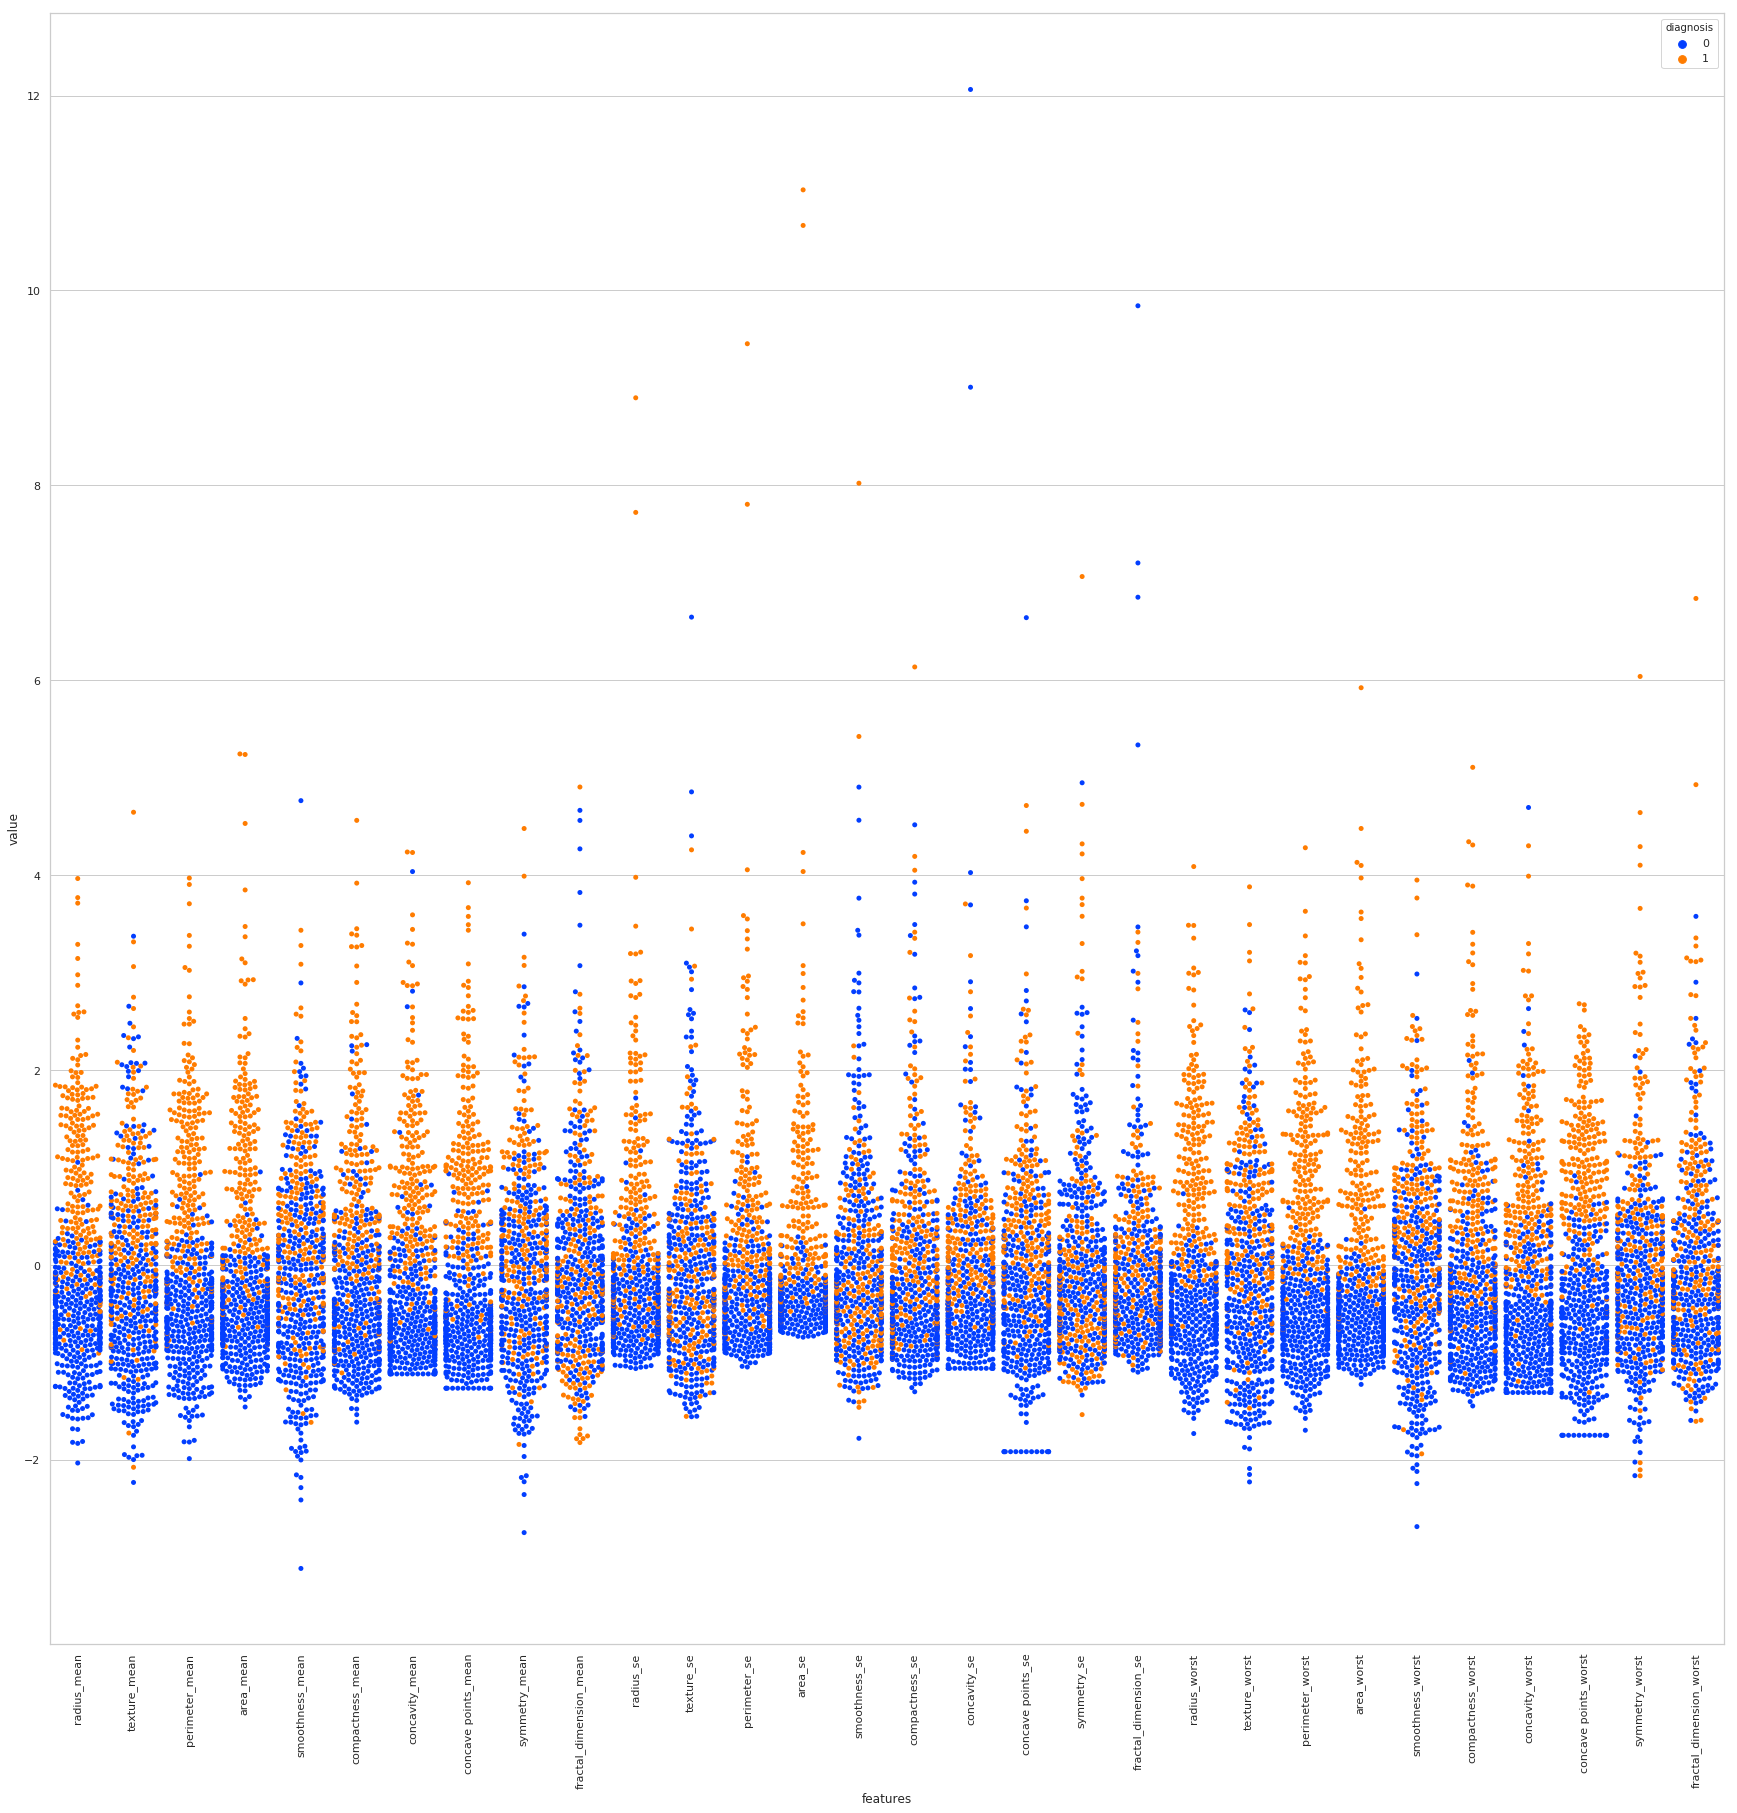

In [18]:
#Plot all data after standardization to confirm that it looks better

sns.set(style="whitegrid", palette="bright")
data_dia = master_diagnosis
data = standardized_features       
data = pd.concat([master_diagnosis,data],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(30,30))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data, size=5)
plt.xticks(rotation=90)

In [52]:
#Split my data into training and testing splits
#I am using stratification on diagnosis to ensure that my splits are representative of the original dataset

features_train, features_test, diagnosis_train, diagnosis_test = train_test_split(standardized_features,master_diagnosis,stratify=master_diagnosis,test_size=0.25,random_state=43)

display(features_train.shape)
display(diagnosis_train.shape)
display(features_test.shape)
display(diagnosis_test.shape)

(426, 30)

(426,)

(143, 30)

(143,)

In [53]:
#Examine testing and training sets to confirm they are representative of the master set
#print("Master Diagnosis Counts:" , "\n" , master_diagnosis.value_counts())
print("Master Diagnosis Mean:",np.mean(master_diagnosis))
print("Master Diagnosis STD:",np.std(master_diagnosis))
#print("Train Diagnosis Counts:" , "\n" , diagnosis_train.value_counts())
print("Train Diagnosis Mean:",np.mean(diagnosis_train))
print("Train Diagnosis STD:",np.std(diagnosis_train))
#print("Test Diagnosis Counts:" , "\n" , diagnosis_test.value_counts())
print("Test Diagnosis Mean:",np.mean(diagnosis_test))
print("Test Diagnosis STD:",np.std(diagnosis_test))





Master Diagnosis Mean: 0.37258347978910367
Master Diagnosis STD: 0.48349253394167957
Train Diagnosis Mean: 0.3732394366197183
Train Diagnosis STD: 0.4836649248927561
Test Diagnosis Mean: 0.3706293706293706
Test Diagnosis STD: 0.4829733328624338


In [23]:
    #Take a look at the columns that are included in the dataset
    display(bcdata.columns) 

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [54]:
# Split dataset into 3 subsets for processing

features_mean = features_train[['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean']].copy()
features_se = features_train[['radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se','fractal_dimension_se']].copy()
features_worst = features_train[['radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst', 'concavity_worst','concave points_worst','symmetry_worst','fractal_dimension_worst']].copy()




(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

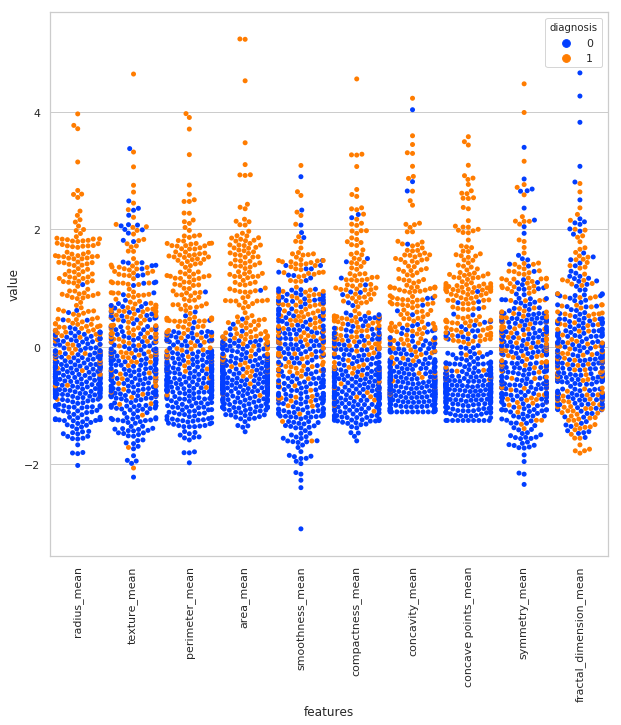

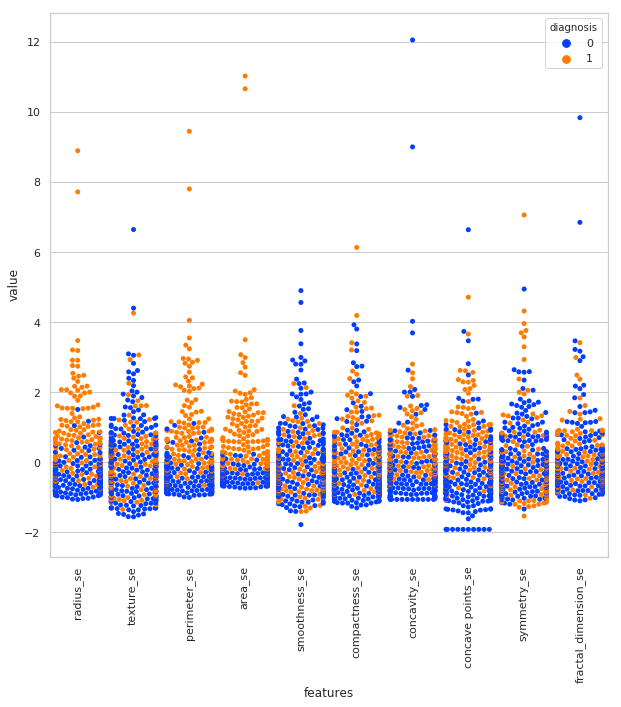

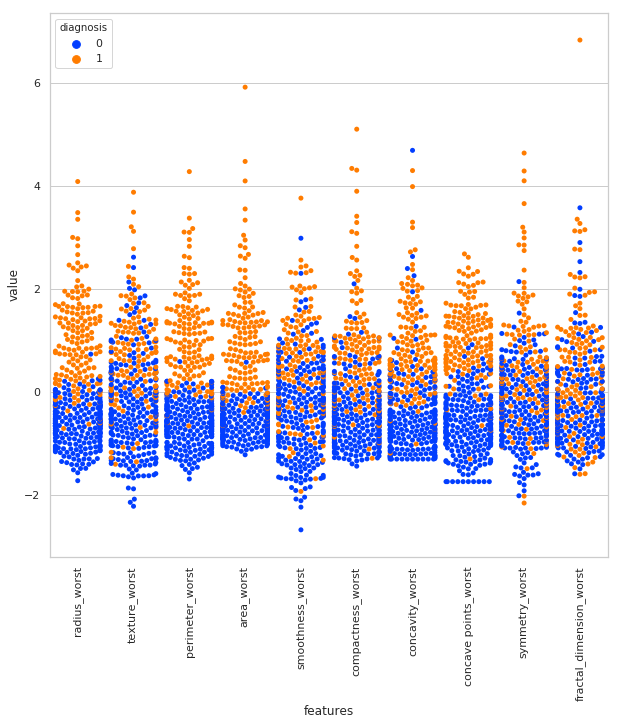

In [64]:
#Scatter plot for each subset
sns.set(style="whitegrid", palette="bright")
data_dia = diagnosis_train
data = features_mean
data = pd.concat([master_diagnosis,data],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data, size=5)
plt.xticks(rotation=90)

sns.set(style="whitegrid", palette="bright")
data_dia = diagnosis_train
data = features_se
data = pd.concat([master_diagnosis,data],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data, size=5)
plt.xticks(rotation=90)

sns.set(style="whitegrid", palette="bright")
data_dia = diagnosis_train
data = features_worst
data = pd.concat([master_diagnosis,data],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data, size=5)
plt.xticks(rotation=90)












In [65]:

#Feature reductions - this section is used to modify test and train feature selections

#Reduced training set to match manually selected feature set from visual inspection
features_selected = features_train[['radius_mean','perimeter_mean','area_mean','concave points_mean','area_se','radius_worst','perimeter_worst','area_worst','concave points_worst']].copy()

#Reducing train feature set to match reduced training set to match manually selected features - visually inspected
reducedfeatures_test = features_test[['radius_mean','perimeter_mean','area_mean','concave points_mean','area_se','radius_worst','perimeter_worst','area_worst','concave points_worst']].copy()












In [66]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    
    results = {}


    start = time() # Get start time
    learner = learner.fit (X_train,y_train)
    end = time() # Get end time
    
    #Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    
    #Calculate the total prediction time
    results['pred_time'] = end - start
            
    #Compute accuracy on the training samples which is y_train
    results['acc_train'] = accuracy_score(y_train,predictions_train)
           
    #Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
        
    #Compute F-score on the the training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train,predictions_train,beta = 0.5)
        
    #Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta = 0.5)
    
   
    # Success
    print ("{} trained and tested".format(learner.__class__.__name__))
        
    # Return the results
    return results

DecisionTreeClassifier trained and tested
AdaBoostClassifier trained and tested
GradientBoostingClassifier trained and tested
SVC trained and tested


{'DecisionTreeClassifier': {'train_time': 0.0035729408264160156,
  'pred_time': 0.0013272762298583984,
  'acc_train': 1.0,
  'acc_test': 0.9300699300699301,
  'f_train': 1.0,
  'f_test': 0.9056603773584906},
 'AdaBoostClassifier': {'train_time': 0.06972503662109375,
  'pred_time': 0.013252973556518555,
  'acc_train': 1.0,
  'acc_test': 0.916083916083916,
  'f_train': 1.0,
  'f_test': 0.8867924528301887},
 'GradientBoostingClassifier': {'train_time': 0.07959628105163574,
  'pred_time': 0.002368927001953125,
  'acc_train': 1.0,
  'acc_test': 0.9370629370629371,
  'f_train': 1.0,
  'f_test': 0.9107806691449815},
 'SVC': {'train_time': 0.0027806758880615234,
  'pred_time': 0.0014407634735107422,
  'acc_train': 0.960093896713615,
  'acc_test': 0.951048951048951,
  'f_train': 0.9548387096774194,
  'f_test': 0.9386973180076628}}

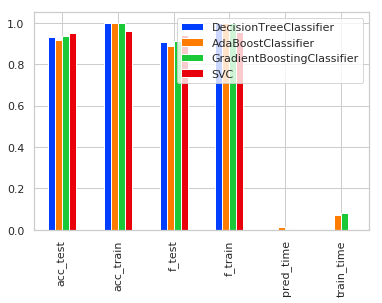

In [67]:
# Initialize models
#
clf_A = DecisionTreeClassifier(random_state = 25)
clf_B = AdaBoostClassifier(random_state = 76)
clf_C = GradientBoostingClassifier(random_state = 65)
clf_D = SVC(kernel="linear",random_state =13)

# Collect results on the learners

#Uncomment/comment X_train and X_test lines to run this section with different feature sets
#features_train is the full training set, Features_selected is the reduced set
#Ensure that the testing set has been reduced to match the features in the reduced training set
#X_train = features_train
X_train = features_selected
#X_test = features_test
X_test = reducedfeatures_test
y_train = diagnosis_train
y_test = diagnosis_test

#loop through the learners
results = {}
for clf in [clf_A,clf_B,clf_C,clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

display(results)

df = pd.DataFrame(results)

df.plot(kind="bar", stacked=False)
plt.show()


In [68]:
def kfoldmodel_analyzer(learner):
    
    display(features_train.shape)
    
    
    kfoldresults={}
    print ("Looking at {}".format(learner.__class__.__name__))

    # Using Recursive feature elimination with cross validation over 10 folds
    # Using full training feature split
    # Stratified Kfold with 10 iterations
    rfecv = RFECV(estimator=learner, step=1, cv=StratifiedKFold(10),scoring='accuracy')
    rfecv.fit(features_train, diagnosis_train)
    
    #Summarize metrics
    print("Optimal number of features : %d" % rfecv.n_features_)
    avgscore = np.mean(rfecv.grid_scores_)
    hiscore = np.amax(rfecv.grid_scores_)
    stddev = np.std(rfecv.grid_scores_)
    print("Average Score :", avgscore )
    print("High Score :", hiscore )
    print("Standard Deviation :", stddev )
    
    kfoldresults['AvgScore'] = avgscore
    kfoldresults['HighScore'] = hiscore
    kfoldresults['Standard Deviation'] = stddev
    kfoldresults['OptimalFeatures'] = rfecv.n_features_
    
    selected_col = rfecv.get_support(indices=True)
    display(features_train.columns[selected_col])
    
    
    
    # Plot number of features and cross-validation scores
    plt.figure()
    plt.title(learner.__class__.__name__)
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    #Citation - http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

    
    return kfoldresults
    



(426, 30)

Optimal number of features : 29
Average Score : 0.9350555960709108
High Score : 0.9483888393701212
Standard Deviation : 0.013938392418736121


Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'compactness_se',
       'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

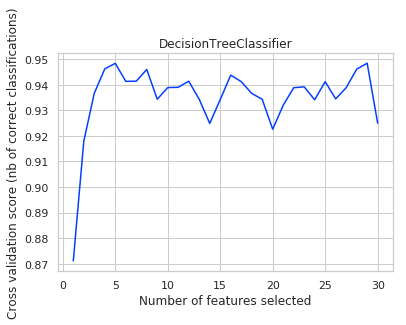

(426, 30)

Optimal number of features : 17
Average Score : 0.9568696485968184
High Score : 0.9717553952948167
Standard Deviation : 0.02390458757392214


Index(['texture_mean', 'smoothness_mean', 'compactness_mean',
       'concave points_mean', 'radius_se', 'area_se', 'compactness_se',
       'concave points_se', 'fractal_dimension_se', 'radius_worst',
       'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

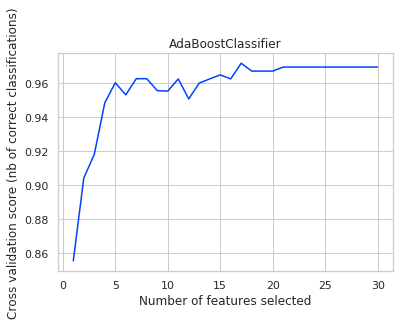

(426, 30)

Optimal number of features : 10
Average Score : 0.9592141821750441
High Score : 0.9695986278799665
Standard Deviation : 0.0173596460856002


Index(['texture_mean', 'concave points_mean', 'texture_se', 'area_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'concavity_worst', 'concave points_worst'],
      dtype='object')

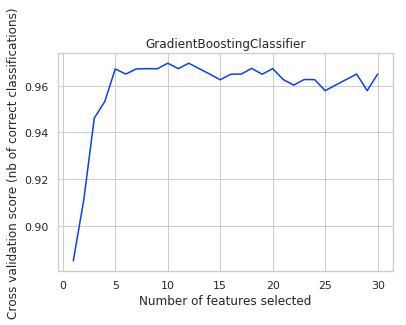

(426, 30)

Optimal number of features : 11
Average Score : 0.9667690354644412
High Score : 0.9788428814520703
Standard Deviation : 0.012087085421910419


Index(['compactness_mean', 'concavity_mean', 'concave points_mean',
       'radius_se', 'texture_se', 'area_se', 'fractal_dimension_se',
       'radius_worst', 'texture_worst', 'area_worst',
       'fractal_dimension_worst'],
      dtype='object')

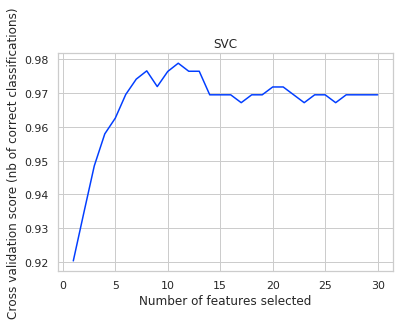

{'DecisionTreeClassifier': {'AvgScore': 0.9350555960709108,
  'HighScore': 0.9483888393701212,
  'Standard Deviation': 0.013938392418736121,
  'OptimalFeatures': 29},
 'AdaBoostClassifier': {'AvgScore': 0.9568696485968184,
  'HighScore': 0.9717553952948167,
  'Standard Deviation': 0.02390458757392214,
  'OptimalFeatures': 17},
 'GradientBoostingClassifier': {'AvgScore': 0.9592141821750441,
  'HighScore': 0.9695986278799665,
  'Standard Deviation': 0.0173596460856002,
  'OptimalFeatures': 10},
 'SVC': {'AvgScore': 0.9667690354644412,
  'HighScore': 0.9788428814520703,
  'Standard Deviation': 0.012087085421910419,
  'OptimalFeatures': 11}}

,DecisionTreeClassifier,AdaBoostClassifier,GradientBoostingClassifier,SVC
AvgScore,0.935056,0.956870,0.959214,0.966769
HighScore,0.948389,0.971755,0.969599,0.978843
OptimalFeatures,29.000000,17.000000,10.000000,11.000000
Standard Deviation,0.013938,0.023905,0.017360,0.012087


In [69]:
# Run Recursive Feature Elimination with Cross Validation on candidate models

clf = {}


#Initialize models
clf_A = DecisionTreeClassifier(random_state = 50)
clf_B = AdaBoostClassifier(random_state = 50)
clf_C = GradientBoostingClassifier(random_state = 50)
clf_D = SVC(kernel="linear",random_state = 50)


#Initialize report array
kfoldresults = {}

#Loop models through RFECV
for clf in [clf_A,clf_B,clf_C,clf_D]:

    clf_name = clf.__class__.__name__
    kfoldresults[clf_name] = {}
    kfoldresults[clf_name] = kfoldmodel_analyzer(clf)

#Display classifier profiling metrics
display(kfoldresults)

df = pd.DataFrame(kfoldresults)
display(df)








Final Training Accuracy: 0.9812206572769953 

Final Testing Accuracy: 0.965034965034965 

Final Training FScore: 0.9857328145265888 

Final Testing FScore: 0.9578544061302681


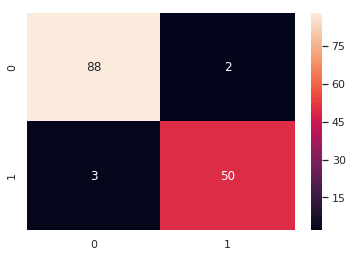

In [71]:
#Final Test

#Feature selection below is driven from the optimal features identified out of the RFE-CV process above

kfoldoptimalfeatures_selected = features_train[['compactness_mean', 'concave points_mean', 'radius_se', 'area_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'concavity_worst', 'concave points_worst']].copy()

finalreducedfeatures_test = features_test[['compactness_mean', 'concave points_mean', 'radius_se', 'area_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'concavity_worst', 'concave points_worst']].copy()

#modify this variable to match the selected final learner from RFE-CV
clf_final = SVC(kernel="linear",random_state = 50)

clf_final.fit(kfoldoptimalfeatures_selected,diagnosis_train)

predictions_train = clf_final.predict(kfoldoptimalfeatures_selected)
predictions_test = clf_final.predict(finalreducedfeatures_test)


acc_train = accuracy_score(diagnosis_train,predictions_train)
acc_test = accuracy_score(diagnosis_test,predictions_test)
f_train = fbeta_score(diagnosis_train,predictions_train,beta = 0.5)
f_test = fbeta_score(diagnosis_test,predictions_test,beta = 0.5)
    
print("Final Training Accuracy:", acc_train,"\n")
print("Final Testing Accuracy:", acc_test,"\n")
print("Final Training FScore:",f_train,"\n")
print("Final Testing FScore:",f_test)

confusionMatrix = confusion_matrix(diagnosis_test,predictions_test)
sns.heatmap(confusionMatrix,annot=True,fmt="d")
    










Sensitivity Training Accuracy: 1.0 

Sensitivity Testing Accuracy: 0.9397163120567376 

Sensitivity Training FScore: 1.0 

Sensitivity Testing FScore: 0.919047619047619


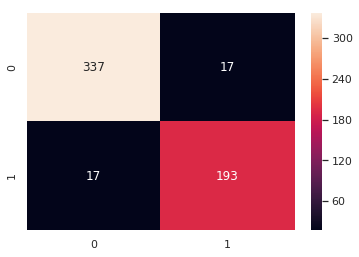

In [73]:
#Sensitivity Analysis - make a fresh train/test split from original data

f_sensitivity_train, f_sensitivity_test, d_sensitivity_train, d_sensitivity_test = train_test_split(standardized_features,master_diagnosis,stratify=master_diagnosis,test_size=0.99)

f_sensitivity_train_reduced = f_sensitivity_train[['compactness_mean', 'concave points_mean', 'radius_se', 'area_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'concavity_worst', 'concave points_worst']].copy()

f_sensitivity_test_reduced = f_sensitivity_test[['compactness_mean', 'concave points_mean', 'radius_se', 'area_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'concavity_worst', 'concave points_worst']].copy()



clf_final = SVC(kernel="linear",random_state = 50)

clf_final.fit(f_sensitivity_train_reduced,d_sensitivity_train)

predictions_train = clf_final.predict(f_sensitivity_train_reduced)
predictions_test = clf_final.predict(f_sensitivity_test_reduced)


acc_train = accuracy_score(d_sensitivity_train,predictions_train)
acc_test = accuracy_score(d_sensitivity_test,predictions_test)
f_train = fbeta_score(d_sensitivity_train,predictions_train,beta = 0.5)
f_test = fbeta_score(d_sensitivity_test,predictions_test,beta = 0.5)
    
print("Sensitivity Training Accuracy:", acc_train,"\n")
print("Sensitivity Testing Accuracy:", acc_test,"\n")
print("Sensitivity Training FScore:",f_train,"\n")
print("Sensitivity Testing FScore:",f_test)

confusionMatrix = confusion_matrix(d_sensitivity_test,predictions_test)
sns.heatmap(confusionMatrix,annot=True,fmt="d")